# ベイズ推定

あるデータ$X$が得られた時のパラメータ$\theta$の事後分布を求める。

$$
p(\theta|X)
$$

MAP推定では事後分布が最大となる$\theta$を求めていたが、ベイズ推定では事後分布そのものを求める。

In [1]:
import torch
import pyro.distributions as dist
import matplotlib.pyplot as plt


---

## 解析的に求める

解析的に求めていく。

MAP推定でも使ったこの例題でやってみる。

> 東京都に住む成人男性の平均身長を求めたい。アンケートを実施して、10000の標本を集めることができた。この10000人分のデータを元に、平均身長を求める。具体的には、身長が正規分布に従うと仮定し、その分布の平均値を求める。なお標準偏差は既知で$\sigma=10$とする。また、日本の成人男性の身長が平均170cm、標準偏差10cmの正規分布に従うことを知っているとする。

標本も同じものを使用する。平均174cm、標準偏差10cmの正規分布。

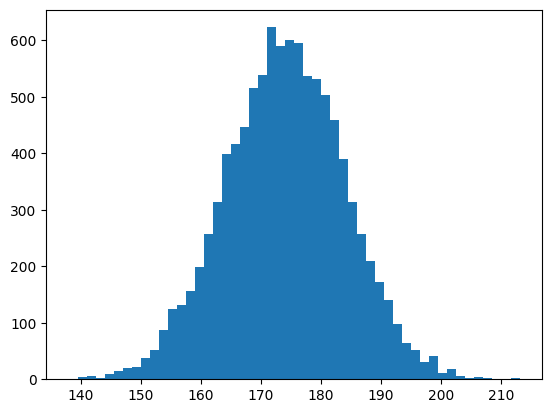

In [2]:
norm = dist.Normal(174, 10)
x = norm.sample((10000,))
plt.hist(x, bins=50);

では求めていく。まずはベイズの定理を使って事後分布を以下のように表す。

$$
p(\theta|X) = \frac{p(X|\theta)p(\theta)}{p(X)} \propto p(X|\theta)p(\theta)
$$

$p(X)$は$\theta$に依存しない定数なので、分布を推定する上では考えなくていい。

$p(X|\theta)$から求める。$X$は正規分布に従い、その分散が10であることまで分かっている為、以下のようにできる。

$$
\begin{align}
p(X|\theta)
    &= \prod_{i=1}^n p(x_i|\theta) \\
    &= \prod_{i=1}^n \mathcal N(x_i;\theta, 10) \\
    &= \prod_{i=1}^n \frac{1}{\sqrt{2\pi \cdot 10^2}} \exp\left(-\frac{(x_i-\theta)^2}{2 \cdot 10^2}\right) \\
    &= \left( \frac{1}{\sqrt{200\pi }} \right)^n \exp \left( -\frac{1}{200}\sum_{i=1}^n (x_i-\theta)^2 \right) \\
\end{align}

ここで指数部分を更に変形する

$$
\begin{align}
\sum_{i=1}^n (x_i-\theta)^2
    &= \sum_{i=1}^n (x_i^2 - 2x_i\theta + \theta^2) \\
    &= \sum_{i=1}^n x_i^2 - 2\theta \sum_{i=1}^n x_i + n\theta^2 \\
\end{align}
$$

でこれは$X$の平均$\bar X$と分散$S^2$を使って

$$
\begin{align}
\bar X &= \frac{1}{n}\sum_{i=1}^n x_i \\
S^2 &= \bar {X^2} - {\bar X}^2 = \frac{1}{n} \sum_{i=1}^n x_i^2 - {\bar X}^2 \\
\end{align}
$$

以下のように進める。

$$
\begin{align}
\sum_{i=1}^n x_i^2 - 2\theta \sum_{i=1}^n x_i + n\theta^2
    &= n(S^2+{\bar X^2}) - 2\theta n\bar X  + n\theta^2 \\
    &= nS^2 + n(\bar X - \theta)^2 \\
\end{align}
$$

これを元の式に代入する。

$$
p(X|\theta) = \left( \frac{1}{\sqrt{200\pi }} \right)^n \exp \left( -\frac{1}{200} (nS^2 + n(\bar X - \theta)^2) \right)
$$

できた

次に事前分布$p(\theta)$を求める。MAP推定同様、平均170、標準偏差10の正規分布としよう。

$$
\begin{align}
p(\theta)
    &= \mathcal N(\theta; 170, 10) \\
    &= \frac{1}{\sqrt{200\pi}} \exp\left(-\frac{(\theta-170)^2}{200}\right) \\
\end{align}
$$

できた

ではこれらをかけていく。

$$
\begin{align}
p(X|\theta)p(\theta)
    &= \left( \frac{1}{\sqrt{200\pi }} \right)^n \exp \left( -\frac{1}{200} (nS^2 + n(\bar X - \theta)^2\right) \frac{1}{\sqrt{200\pi}} \exp\left(-\frac{(\theta-170)^2}{200} \right) \\
    &\propto \exp \left( -\frac{1}{200} (nS^2 + n(\bar X - \theta)^2 -(\theta-170)^2) \right) \\
    &= \exp \left( -\frac{1}{200} (n(\bar X - \theta)^2 -(\theta-170)^2) \right) \exp \left( -\frac{1}{200} nS^2 \right) \\
    &\propto \exp \left( -\frac{1}{200} (n(\bar X - \theta)^2 -(\theta-170)^2) \right)
\end{align}
$$

例によって$\theta$に関係のない部分は無視する。

ここで、指数の中を$-\frac{(\theta-\mu)^2}{2\sigma^2}$の形にできれば、$\mathcal N(\theta;\mu,\sigma^2)$と比例の関係で表せるので、それを目指す。

ではどうすればその形になるかというと、$\theta$について平方完成をすればいい。  
やってみよう。

$$
\begin{align}
n(\bar X - \theta)^2 -(\theta-170)^2 = 
\end{align}

173.96560343965604 0.10000500037503125


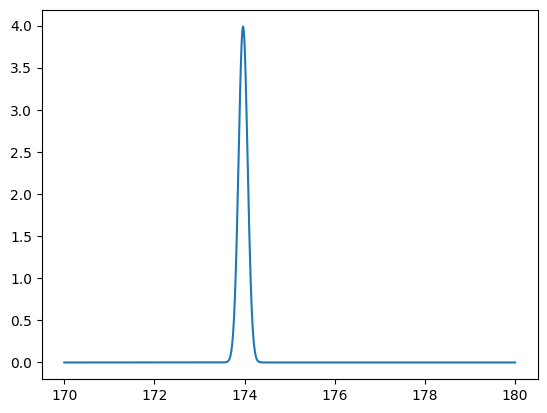

In [12]:
n = 10000
bar_x = 174

mu = (bar_x*n - 170) / (n+1)
sigma = 10 / (n-1)**0.5
print(mu, sigma)

posterior = dist.Normal(mu, sigma)

t = torch.linspace(170, 180, 1000)
y = posterior.log_prob(t).exp()
plt.plot(t, y);


---

## MCMC法

マルコフ連鎖モンテカルロ法（*Markov Chain Monte Carlo Method*)

求めたい事後分布に従う数列を生成する方法．色々方法がある．

- メトロポリス・ヘイスティング法
- ハミルトニアン・モンテカルロ法
- ギブズサンプリング
- スライスサンプリング


---

## 変分推論

変分ベイズとも

事後分布$P(\theta|x$)を別の分布$q(\theta)$で近似する手法．